### Module 1+2 – Genetic Algorithm based LSTM

This module finds **optimal hyperparameters** for the LSTM-based traffic flow predictor  
using a **Genetic Algorithm (GA)**.

### Hyperparameters to Optimize
| Symbol | Parameter | Range | Description |
|:--:|:--|:--|:--|
| L | Lookback window | [6, 24] | Past time steps used as input |
| u | Hidden units | [32, 128] | LSTM neuron count |
| d | Dropout rate | [0.1, 0.5] | Regularization |
| α | Learning rate | [1e-4, 5e-3] | Step size for gradient descent |
| B | Batch size | [32, 128] | Samples per update |
| Opt | Optimizer | {Adam, RMSprop, SGD} | Optimization algorithm |

**Objective:** minimize validation **Mean Squared Error (MSE)**.  
After finding the best hyperparameters, we **retrain the LSTM fully** and **save it for deployment**.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from sklearn.preprocessing import MinMaxScaler
import random
import matplotlib.pyplot as plt
path = '/content/drive/MyDrive/Traffic_Project/metr_la_speed.csv'
df = pd.read_csv(path)
data = df.drop(columns=['timestamp']).values

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
print("Data loaded and normalized:", data_scaled.shape)


Data loaded and normalized: (34272, 207)


In [45]:
def create_windows(series, lookback=12, horizon=1):
    X, y = [], []
    for i in range(len(series) - lookback - horizon):
        X.append(series[i:i+lookback])
        y.append(series[i+lookback+horizon-1])
    return np.array(X), np.array(y)


In [46]:

param_bounds = {
    'L': (6, 24),
    'u': (32, 128),
    'd': (0.1, 0.5),
    'alpha': (1e-4, 5e-3),
    'B': (32, 128)
}
optimizers = ['adam', 'rmsprop', 'sgd']

POP_SIZE = 6
GENERATIONS = 5
EPOCHS_PER_INDIVIDUAL = 30

In [47]:
def build_lstm(L, u, alpha, d, optimizer_name):
    n_features = data_scaled.shape[1]
    if optimizer_name == 'adam':
        opt = Adam(learning_rate=alpha)
    elif optimizer_name == 'rmsprop':
        opt = RMSprop(learning_rate=alpha)
    else:
        opt = SGD(learning_rate=alpha, momentum=0.9)

    model = Sequential([
        LSTM(u, input_shape=(L, n_features), return_sequences=False),
        Dropout(d),
        Dense(n_features)
    ])
    model.compile(optimizer=opt, loss='mse')
    return model

def evaluate_fitness(params):
    L, u, d, alpha, B, optimizer_name = params
    X, y = create_windows(data_scaled, int(L))
    split = int(0.8 * len(X))
    X_train, X_val = X[:split], X[split:]
    y_train, y_val = y[:split], y[split:]

    model = build_lstm(int(L), int(u), alpha, d, optimizer_name)
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS_PER_INDIVIDUAL,
        batch_size=int(B),
        validation_data=(X_val, y_val),
        verbose=0
    )
    mse = history.history['val_loss'][-1]
    tf.keras.backend.clear_session()
    return mse


In [48]:
def random_chromosome():
    return [
        random.randint(*param_bounds['L']),
        random.randint(*param_bounds['u']),
        random.uniform(*param_bounds['d']),
        random.uniform(*param_bounds['alpha']),
        random.randint(*param_bounds['B']),
        random.choice(optimizers)
    ]

def crossover(p1, p2):
    cut = random.randint(1, len(p1)-2)
    return p1[:cut] + p2[cut:]

def mutate(chromosome, rate=0.2):
    if random.random() < rate:
        i = random.randint(0, len(param_bounds)-1)
        key = list(param_bounds.keys())[i]
        bounds = param_bounds[key]
        chromosome[i] = (
            random.randint(*bounds) if isinstance(bounds[0], int)
            else random.uniform(*bounds)
        )
    if random.random() < 0.1:
        chromosome[-1] = random.choice(optimizers)
    return chromosome


In [49]:
population = [random_chromosome() for _ in range(POP_SIZE)]
all_records = []

for gen in range(GENERATIONS):
    print(f"\nGeneration {gen+1}/{GENERATIONS}")
    fitness = [evaluate_fitness(ind) for ind in population]

    ranked = sorted(zip(fitness, population), key=lambda x: x[0])
    best_fit, best_params = ranked[0]
    print(f"Best MSE = {best_fit:.6f} | Best Params = {best_params}")
    all_records.append((gen+1, best_fit, best_params))

    parents = [p for _, p in ranked[:2]]

    children = []
    while len(children) < POP_SIZE - len(parents):
        p1, p2 = random.sample(parents, 2)
        child = crossover(p1, p2)
        child = mutate(child)
        children.append(child)

    population = parents + children

fitness = [evaluate_fitness(ind) for ind in population]
best_idx = np.argmin(fitness)
best_params = population[best_idx]

print("\nOptimal Hyperparameters Found by GA:")
print(f"L={best_params[0]}, u={best_params[1]}, d={best_params[2]:.3f}, "
      f"α={best_params[3]:.5f}, B={best_params[4]}, optimizer={best_params[5]}")



Generation 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best MSE = 0.018706 | Best Params = [17, 97, 0.34706618906817616, 0.002802673968660549, 67, 'rmsprop']

Generation 2/5
Best MSE = 0.018263 | Best Params = [7, 121, 0.34706618906817616, 0.002802673968660549, 67, 'rmsprop']

Generation 3/5
Best MSE = 0.016574 | Best Params = [7, 121, 0.18353101283380205, 0.002802673968660549, 67, 'rmsprop']

Generation 4/5
Best MSE = 0.016870 | Best Params = [7, 121, 0.18353101283380205, 0.002802673968660549, 67, 'rmsprop']

Generation 5/5
Best MSE = 0.016543 | Best Params = [7, 121, 0.18353101283380205, 0.002802673968660549, 67, 'rmsprop']

Optimal Hyperparameters Found by GA:
L=7, u=121, d=0.184, α=0.00280, B=67, optimizer=rmsprop


In [50]:
L, u, d, alpha, B, optimizer_name = best_params

X, y = create_windows(data_scaled, int(L))
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

final_model = build_lstm(int(L), int(u), alpha, d, optimizer_name)
history = final_model.fit(
    X_train, y_train, epochs=500,
    batch_size=int(B), validation_data=(X_val, y_val),
    verbose=1
)

save_path = '/content/drive/MyDrive/Traffic_Project/metr_lstm_ga_optimized.h5'
final_model.save(save_path)
print(f"Final GA-optimized model saved at: {save_path}")


Epoch 1/500
410/410 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0741 - val_loss: 0.0307
Epoch 2/500
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0298 - val_loss: 0.0301
Epoch 3/500
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0242 - val_loss: 0.0352
Epoch 4/500
410/410 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0214 - val_loss: 0.0247
Epoch 5/500
410/410 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0195 - val_loss: 0.0254
Epoch 6/500
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0180 - val_loss: 0.0225
Epoch 7/500
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0171 - val_loss: 0.0222
Epoch 8/500
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0166 - val_loss: 0.0216
Epoch 9/500
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0155 - val_loss: 0.0205
Epoch 10/500
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0152 - val_loss: 0.0199
Epoch 11/500
410/410 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0148 - val_loss: 0.0204
Epoch 12/500
410/410 ━━━━━━━━━━━━━━━━━━━━

Final GA-optimized model saved at: /content/drive/MyDrive/Traffic_Project/metr_lstm_ga_optimized.h5


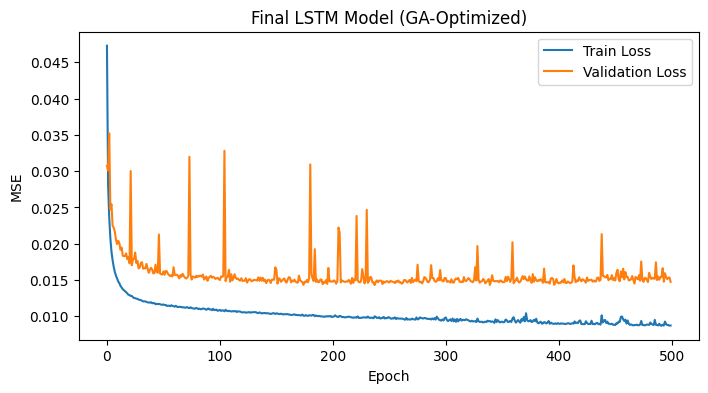

In [51]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Final LSTM Model (GA-Optimized)')
plt.legend()
plt.show()


In [52]:
import pandas as pd

records_df = pd.DataFrame(all_records, columns=['Generation', 'Best_MSE', 'Best_Params'])
records_df.to_csv('/content/drive/MyDrive/Traffic_Project/ga_tuning_log.csv', index=False)
records_df


,Generation,Best_MSE,Best_Params
0,1,0.018706,"[17, 97, 0.34706618906817616, 0.00280267396866..."
1,2,0.018263,"[7, 121, 0.34706618906817616, 0.00280267396866..."
2,3,0.016574,"[7, 121, 0.18353101283380205, 0.00280267396866..."
3,4,0.016870,"[7, 121, 0.18353101283380205, 0.00280267396866..."
4,5,0.016543,"[7, 121, 0.18353101283380205, 0.00280267396866..."


# Module 3 – Particle Swarm Optimization (PSO) for Traffic Signal Control

**Goal:**  
Optimize traffic signal parameters using PSO to minimize vehicle delay based on predicted traffic flows.

**Parameters Optimized:**  
- Cycle time (C)  
- Green splits per approach (S₁, S₂, ...)  
- Offsets (O)  

**Fitness Function:**  
Average delay = weighted sum of waiting time and queue length across all approaches.


In [9]:
model_path = '/content/drive/MyDrive/Traffic_Project/metr_lstm_ga_optimized.h5'
data_path  = '/content/drive/MyDrive/Traffic_Project/metr_la_speed.csv'

model = tf.keras.models.load_model(model_path, compile=False)
df = pd.read_csv(data_path)
data = df.drop(columns=['timestamp']).values if 'timestamp' in df.columns else df.values
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)


In [11]:
lookback = 12
def create_windows(series, lookback=12):
    X=[]
    for i in range(len(series)-lookback):
        X.append(series[i:i+lookback])
    return np.array(X)

X = create_windows(data_scaled, lookback)
y_pred = model.predict(X, verbose=0)
y_pred_actual = scaler.inverse_transform(y_pred)
print("Predictions shape:", y_pred_actual.shape)


Predictions shape: (34260, 207)


In [19]:
density = 60
last_speeds = y_pred_actual[-1]
predicted_flow = last_speeds * density
print("Predicted_flow shape:", predicted_flow.shape)


Predicted_flow shape: (207,)


In [20]:
import numpy as np
import matplotlib.pyplot as plt

flows_matrix = predicted_flow[:12].reshape(3, 4)
print("Flows (veh/hr) for 3 intersections × 4 approaches:")
print(flows_matrix)


Flows (veh/hr) for 3 intersections × 4 approaches:
[[3825.5142 3773.3577 3963.6099 3333.189 ]
 [3225.1538 3217.5234 3644.4434 3665.7021]
 [3623.8892 4178.1294 3505.2092 3995.7065]]


In [21]:
N_intersections = 3
approaches_per_inter = 4
vars_per_inter = 6  # [C, r1, r2, r3, r4, offset]
dim = N_intersections * vars_per_inter

C_bounds = (40.0, 140.0)
r_bounds = (0.05, 2.0)
O_bounds = (0.0, 140.0)

bounds = []
for _ in range(N_intersections):
    bounds.append(C_bounds)
    for _ in range(4):
        bounds.append(r_bounds)
    bounds.append(O_bounds)
bounds = np.array(bounds)


def progression_penalty(particle):
    penalties = []
    for i in range(N_intersections - 1):
        C_i = particle[i*vars_per_inter + 0]
        O_i = particle[i*vars_per_inter + 5]
        C_j = particle[(i+1)*vars_per_inter + 0]
        O_j = particle[(i+1)*vars_per_inter + 5]
        travel_time = distances_m[i] / v_prog_mps
        ideal = (O_i + travel_time) % C_j
        diff = min(abs(ideal - O_j), C_j - abs(ideal - O_j))
        penalties.append(diff)
    return np.mean(penalties)


In [31]:
def akcelik_delay(q_vph, g_s, C_s, s_vph=1800):
    """
    Akçelik delay model (empirical + analytic)
    Handles both under- and over-saturated intersections.
    Returns delay in seconds per vehicle.
    """
    q = q_vph / 3600.0
    s = s_vph / 3600.0
    g_over_C = np.clip(g_s / C_s, 0.05, 0.95)
    X = q / (s * g_over_C + 1e-9)
    X = max(X, 1e-6)
    T = C_s / 3600.0

    term1 = 0.5 * C_s * (1 - g_over_C)**2 / max(1e-6, (1 - min(1, X) * g_over_C))
    term2 = (900 * T * max(0, X - 1) + 5 * max(0, (X - 1))**2) / X

    return term1 + term2

def fitness_function(p):
    total = 0.0
    for k in range(N_intersections):
        base = k * vars_per_inter
        Ck = p[base]
        raw_rs = np.maximum(p[base+1:base+5], 1e-6)
        rs = raw_rs / np.sum(raw_rs)
        greens = rs * Ck
        flows = flows_matrix[k]
        for j in range(4):
            total += akcelik_delay(flows[j], greens[j], Ck)
    return total / (N_intersections * 4)




In [35]:
NUM_PARTICLES = 25
MAX_ITERS = 20
w, c1, c2 = 0.9, 2.0, 2.0

positions = np.random.uniform(bounds[:,0], bounds[:,1], (NUM_PARTICLES, dim))
velocities = np.zeros_like(positions)
pbest_pos = positions.copy()
pbest_scores = np.array([fitness_function(p) for p in positions])
gbest_idx = np.argmin(pbest_scores)
gbest_pos = pbest_pos[gbest_idx].copy()
gbest_score = pbest_scores[gbest_idx]

print("Initial best fitness:", gbest_score)

history = []

for it in range(MAX_ITERS):
    for i in range(NUM_PARTICLES):
        r1, r2 = np.random.rand(dim), np.random.rand(dim)
        velocities[i] = (
            w * velocities[i]
            + c1 * r1 * (pbest_pos[i] - positions[i])
            + c2 * r2 * (gbest_pos - positions[i])
        )
        positions[i] += velocities[i]
        positions[i] = np.clip(positions[i], bounds[:,0], bounds[:,1])

        for k in range(N_intersections):
            base = k * vars_per_inter
            Ck = positions[i, base]
            positions[i, base+5] = positions[i, base+5] % max(Ck, 1e-6)

        score = fitness_function(positions[i])
        if score < pbest_scores[i]:
            pbest_scores[i] = score
            pbest_pos[i] = positions[i].copy()

    best_idx = np.argmin(pbest_scores)
    if pbest_scores[best_idx] < gbest_score:
        gbest_score = pbest_scores[best_idx]
        gbest_pos = pbest_pos[best_idx].copy()
    history.append(gbest_score)

    if it % 5 == 0 or it == MAX_ITERS - 1:
        print(f"Iter {it+1}/{MAX_ITERS} | Best fitness = {gbest_score:.4f}")


Initial best fitness: 86.84530034670983
Iter 1/20 | Best fitness = 77.1584
Iter 6/20 | Best fitness = 55.2185
Iter 11/20 | Best fitness = 55.0538
Iter 16/20 | Best fitness = 55.0486
Iter 20/20 | Best fitness = 55.0484


In [40]:
print("Best fitness (delay):", gbest_score)
print("Best solution vector:", gbest_pos)

np.savez("/content/drive/MyDrive/Traffic_Project/pso_results.npz",
         gbest=gbest_pos, flows_matrix=flows_matrix, history=history)


Best fitness (delay): 55.048362677376
Best solution vector: [40.          2.          2.          2.          1.86421059  0.
 40.          2.          2.          2.          2.          0.
 40.          1.88051074  2.          1.86677514  2.          0.        ]


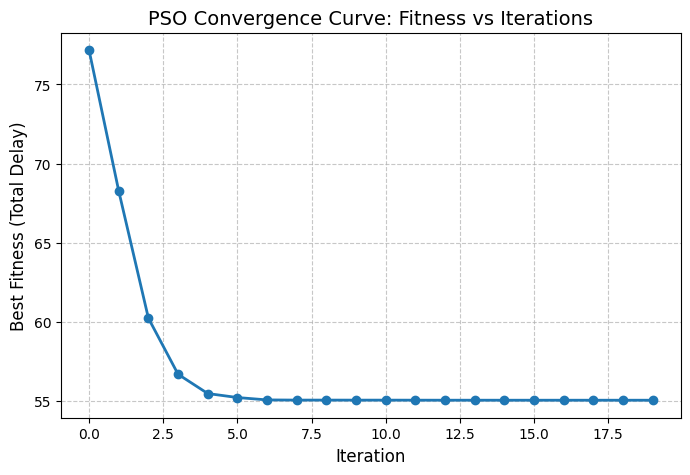

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history, marker='o', linestyle='-', linewidth=2)
plt.title("PSO Convergence Curve: Fitness vs Iterations", fontsize=14)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Best Fitness (Total Delay)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


# Module 4 — Mamdani Fuzzy Logic Controller

To design a **fuzzy logic controller** that dynamically adjusts the **traffic signal cycle time** based on real-time conditions such as **queue length** and **delay**.

This module refines the PSO-optimized signal timings by introducing adaptive control using **Mamdani inference**, allowing cycle lengths to increase or decrease depending on current congestion.

---

## Inputs and Outputs

| Variable | Type | Description | Range | Unit |
|-----------|------|--------------|--------|------|
| Queue (Q) | Input | Number of vehicles in queue | 0–35 | vehicles |
| Delay (D) | Input | Average vehicle delay | 0–120 | seconds |
| ΔCycle | Output | Change in signal cycle | -10–10 | seconds |

---



## Rule Base 

Rules use **AND (min)** operations.

| Queue | Delay | ΔCycle |
|--------|--------|---------|
| Low | Low | Decrease |
| Low | Medium | NoChange |
| Low | High | NoChange |
| Medium | Low | NoChange |
| Medium | Medium | NoChange |
| Medium | High | Increase |
| High | Low | NoChange |
| High | Medium | Increase |
| High | High | Increase |



In [49]:
import numpy as np

data = np.load("/content/drive/MyDrive/Traffic_Project/pso_results.npz", allow_pickle=True)
gbest = data["gbest"]
flows_matrix = data["flows_matrix"]

vars_per_inter = 1 + 4 + 1
N_intersections = len(flows_matrix)

base_signals = []
for i in range(N_intersections):
    base = i * vars_per_inter
    cycle = gbest[base]
    splits = gbest[base+1:base+5] / np.sum(gbest[base+1:base+5])
    offset = gbest[base+5]
    base_signals.append({"cycle": cycle, "splits": splits, "offset": offset})


In [62]:
import numpy as np
import matplotlib.pyplot as plt

def triangular(x, a, b, c):
    if x <= a or x >= c:
        if a == b and x == b: return 1.0
        if b == c and x == b: return 1.0
        return 0.0
    if a < x < b:
        return (x - a) / (b - a) if (b - a) != 0 else 1.0
    if b <= x < c:
        return (c - x) / (c - b) if (c - b) != 0 else 1.0
    return 0.0


q_mfs = {
    'Low':    (0, 0, 10),
    'Medium': (5, 15, 25),
    'High':   (20, 30, 35)
}

d_mfs = {
    'Low':    (0, 0, 40),
    'Medium': (20, 60, 100),
    'High':   (80, 120, 120)
}

out_mfs = {
    'Decrease': (-10, -10, 0),
    'NoChange': (-5, 0, 5),
    'Increase': (0, 10, 10)
}
rules = [
    ('Low', 'Low', 'Decrease'),
    ('Low', 'Medium', 'NoChange'),
    ('Low', 'High', 'NoChange'),
    ('Medium', 'Low', 'NoChange'),
    ('Medium', 'Medium', 'NoChange'),
    ('Medium', 'High', 'Increase'),
    ('High', 'Low', 'NoChange'),
    ('High', 'Medium', 'Increase'),
    ('High', 'High', 'Increase')
]

def fuzzify(value, mf_dict):
    return {term: triangular(value, *params) for term, params in mf_dict.items()}


def mamdani_controller(Q, D, resolution=201):
    q_deg = fuzzify(Q, q_mfs)
    d_deg = fuzzify(D, d_mfs)

    rule_acts = []
    for qterm, dterm, outterm in rules:
        act = min(q_deg[qterm], d_deg[dterm])
        rule_acts.append((act, outterm))

    x = np.linspace(-10, 10, resolution)
    agg = np.zeros_like(x)

    for act, outterm in rule_acts:
        if act <= 0: continue
        a,b,c = out_mfs[outterm]
        mf_vals = np.array([min(triangular(xx,a,b,c), act) for xx in x])
        agg = np.maximum(agg, mf_vals)

    if np.sum(agg) == 0:
        return 0.0

    deltaC = np.sum(x * agg) / np.sum(agg)
    return float(deltaC)

Q = 25  # queue
D = 55  # delay
deltaC = mamdani_controller(Q, D)
print(f"Queue={Q}, Delay={D} → ΔCycle={deltaC:.2f} sec")

C_base = 120
C_new = C_base + deltaC
print(f"Base cycle: {C_base}s → New cycle: {C_new:.2f}s")

Queue=25, Delay=55 → ΔCycle=6.14 sec
Base cycle: 120s → New cycle: 126.14s


# Module 5 — Adaptive Neuro-Fuzzy Inference System (ANFIS)

---

## Objective

To develop a **hybrid adaptive controller** that merges the interpretability of fuzzy systems with the self-learning ability of neural networks.  
This allows the traffic controller to **automatically tune** its fuzzy membership functions and rule parameters based on historical data (e.g., queue length, delay).



In [81]:
def tri(x, a, b, c):
    if x <= a or x >= c:
        if a == b and x == b: return 1
        if b == c and x == b: return 1
        return 0
    if a < x < b: return (x - a) / (b - a)
    if b <= x < c: return (c - x) / (c - b)
    return 0

q_mf = {'Low': (0, 0, 10), 'Med': (5, 15, 25), 'High': (20, 30, 35)}
d_mf = {'Low': (0, 0, 40), 'Med': (20, 60, 100), 'High': (80, 120, 120)}
out_mf = {'Dec': (-10, -10, 0), 'No': (-5, 0, 5), 'Inc': (0, 10, 10)}
rules = [('Low', 'Low', 'Dec'), ('Low', 'Med', 'No'), ('Low', 'High', 'No'),
         ('Med', 'Low', 'No'), ('Med', 'Med', 'No'), ('Med', 'High', 'Inc'),
         ('High', 'Low', 'No'), ('High', 'Med', 'Inc'), ('High', 'High', 'Inc')]

def fuzzify(x, sets):
    return {k: tri(x, *v) for k, v in sets.items()}

def mamdani(Q, D, res=101):
    q = fuzzify(Q, q_mf)
    d = fuzzify(D, d_mf)
    acts = []
    for qterm, dterm, outterm in rules:
        a = min(q[qterm], d[dterm])
        acts.append((a, outterm))
    x = np.linspace(-10, 10, res)
    agg = np.zeros_like(x)
    for a, term in acts:
        A, B, C = out_mf[term]
        mf = np.array([min(tri(xx, A, B, C), a) for xx in x])
        agg = np.maximum(agg, mf)
    return np.sum(x * agg) / np.sum(agg) if np.sum(agg) != 0 else 0

N = 500
np.random.seed(42)
Q = np.random.uniform(0, 35, N)
D = np.random.uniform(0, 120, N)
y = np.array([mamdani(Q[i], D[i]) for i in range(N)])
data = np.stack([Q, D, y], axis=1)
print("Training data shape:", data.shape)

Training data shape: (500, 3)


In [88]:
class ANFIS:
    def __init__(self, n_rules=9, lr=0.01):
        self.n_rules = n_rules; self.lr = lr
        self.cQ = np.random.uniform(0, 1, n_rules)
        self.sQ = np.ones(n_rules) * 0.5
        self.cD = np.random.uniform(0, 1, n_rules)
        self.sD = np.ones(n_rules) * 0.5
        self.p = np.random.randn(n_rules)
        self.r = np.random.randn(n_rules)
        self.s = np.random.randn(n_rules)
        self.scalers = {}

    def _normalize(self, data):
        Q, D, y = data.T
        self.scalers['Q'] = (Q.min(), Q.max())
        self.scalers['D'] = (D.min(), D.max())
        self.scalers['y'] = (y.min(), y.max())
        Q_norm = (Q - self.scalers['Q'][0]) / (self.scalers['Q'][1] - self.scalers['Q'][0])
        D_norm = (D - self.scalers['D'][0]) / (self.scalers['D'][1] - self.scalers['D'][0])
        y_norm = (y - self.scalers['y'][0]) / (self.scalers['y'][1] - self.scalers['y'][0])
        return np.stack([Q_norm, D_norm, y_norm], axis=1)

    def _denormalize_y(self, y_norm):
        min_y, max_y = self.scalers['y']
        return y_norm * (max_y - min_y) + min_y

    def gauss(self, x, c, s):
        safe_s = np.maximum(np.abs(s), 1e-9)
        return np.exp(-0.5 * ((x - c) / safe_s)**2)

    def forward(self, Q_norm, D_norm):
        μQ = self.gauss(Q_norm, self.cQ, self.sQ)
        μD = self.gauss(D_norm, self.cD, self.sD)
        w = μQ * μD
        f_i = self.p * Q_norm + self.r * D_norm + self.s
        sum_w = np.sum(w)
        if sum_w == 0: return 0, np.zeros(self.n_rules), w, f_i
        w_norm = w / sum_w; y_hat = np.sum(w_norm * f_i)
        return y_hat, w_norm, w, f_i

    def train(self, data, epochs=100):
        data_norm = self._normalize(data)
        mse_hist = []
        for ep in range(epochs):
            total_err_norm = 0; np.random.shuffle(data_norm)
            for Q_norm, D_norm, y_norm in data_norm:
                y_hat_norm, w_norm, w, f_i = self.forward(Q_norm, D_norm)
                err_norm = y_norm - y_hat_norm; total_err_norm += err_norm**2
                sum_w = np.sum(w)
                if sum_w < 1e-9: continue
                self.p += self.lr * err_norm * w_norm * Q_norm
                self.r += self.lr * err_norm * w_norm * D_norm
                self.s += self.lr * err_norm * w_norm
                common_term = err_norm * (f_i - y_hat_norm) / sum_w
                safe_sQ = np.maximum(np.abs(self.sQ), 1e-6); safe_sD = np.maximum(np.abs(self.sD), 1e-6)
                grad_cQ = common_term * w * (Q_norm - self.cQ) / safe_sQ**2
                grad_sQ = common_term * w * (Q_norm - self.cQ)**2 / safe_sQ**3
                grad_cD = common_term * w * (D_norm - self.cD) / safe_sD**2
                grad_sD = common_term * w * (D_norm - self.cD)**2 / safe_sD**3

                grad_clip = 1.0

                self.cQ += self.lr * np.clip(grad_cQ, -grad_clip, grad_clip)
                self.sQ += self.lr * np.clip(grad_sQ, -grad_clip, grad_clip)
                self.cD += self.lr * np.clip(grad_cD, -grad_clip, grad_clip)
                self.sD += self.lr * np.clip(grad_sD, -grad_clip, grad_clip)
            y_pred = self.predict(data[:, :2]); mse = np.mean((data[:, 2] - y_pred)**2)
            mse_hist.append(mse)
            if (ep + 1) % 25 == 0 or ep == 0: print(f"Epoch {ep+1} | MSE={mse:.4f}")
        return mse_hist

    def predict(self, X):
        if not self.scalers: raise Exception("Model has not been trained yet.")
        Q, D = X.T
        Q_norm = (Q - self.scalers['Q'][0]) / (self.scalers['Q'][1] - self.scalers['Q'][0])
        D_norm = (D - self.scalers['D'][0]) / (self.scalers['D'][1] - self.scalers['D'][0])
        y_hats_norm = np.array([self.forward(q, d)[0] for q, d in zip(Q_norm, D_norm)])
        return self._denormalize_y(y_hats_norm)

Epoch 1 | MSE=19.3106
Epoch 25 | MSE=2.2110
Epoch 50 | MSE=2.1454
Epoch 75 | MSE=2.0995
Epoch 100 | MSE=2.0487
Epoch 125 | MSE=1.9828
Epoch 150 | MSE=1.8801
Epoch 175 | MSE=1.7269
Epoch 200 | MSE=1.5940
Epoch 225 | MSE=1.4577
Epoch 250 | MSE=1.2767
Epoch 275 | MSE=1.1769
Epoch 300 | MSE=1.0704
Epoch 325 | MSE=0.9543
Epoch 350 | MSE=0.8533
Epoch 375 | MSE=0.7821
Epoch 400 | MSE=0.7005
Epoch 425 | MSE=0.6696
Epoch 450 | MSE=0.5916
Epoch 475 | MSE=0.5123
Epoch 500 | MSE=0.4891
Epoch 525 | MSE=0.4654
Epoch 550 | MSE=0.4500
Epoch 575 | MSE=0.4202
Epoch 600 | MSE=0.3938
Epoch 625 | MSE=0.3787
Epoch 650 | MSE=0.3631
Epoch 675 | MSE=0.3520
Epoch 700 | MSE=0.3347
Epoch 725 | MSE=0.3290
Epoch 750 | MSE=0.2990
Epoch 775 | MSE=0.2753
Epoch 800 | MSE=0.2546
Epoch 825 | MSE=0.2424
Epoch 850 | MSE=0.2378
Epoch 875 | MSE=0.2438
Epoch 900 | MSE=0.2383
Epoch 925 | MSE=0.2573
Epoch 950 | MSE=0.2329
Epoch 975 | MSE=0.2438
Epoch 1000 | MSE=0.2284


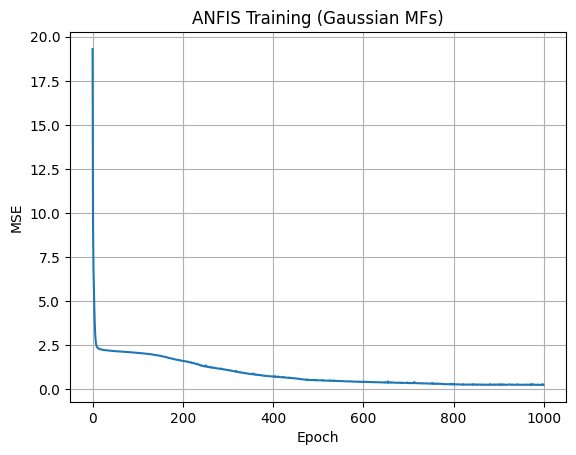

In [89]:
anfis=ANFIS(n_rules=9,lr=0.005)
losses=anfis.train(data,epochs=1000)

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("ANFIS Training (Gaussian MFs)")
plt.grid(True)
plt.show()
